### Shor's Algorithm
#### Simplify version in Qiskit Learning

In [19]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from qiskit.primitives import Sampler
from qiskit.visualization import plot_histogram

#### Implementation in Qiskit

Here's example for Shor's algorithm in Qiskit to factor number 15.

First we'll hard code a controlled-multiplication operation for a given

In [20]:
def c_amod15(a):
    """
    Controlled multiplication by a mod 15.
    This is hard-coded for simplicity.

    promise that input would only be 2, 4, 7, 8, 11 and 13
    """
    if a not in [2, 4, 7, 8, 11, 13]:
        raise ValueError("'a' must not have common factors with 15")
    U = QuantumCircuit(4)
    if a in [2, 13]:
        U.swap(2, 3)
        U.swap(1, 2)
        U.swap(0, 1)
    if a in [7, 8]:
        U.swap(0, 1)
        U.swap(1, 2)
        U.swap(2, 3)
    if a in [4, 11]:
        U.swap(1, 3)
        U.swap(0, 2)
    if a in [7, 11, 13]:
        for q in range(4):
            U.x(q)
    display(U.draw('mpl'))
    U = U.to_gate()
    U.name = f"{a} mod 15"
    c_U = U.control()
    return c_U

Here're the hard-coded U to multiplication operation for 2


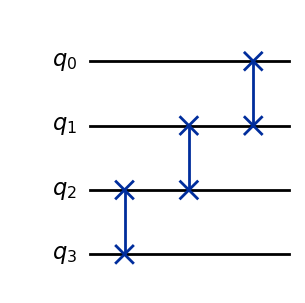

Instruction(name='c2 mod 15', num_qubits=5, num_clbits=0, params=[])
Here're the hard-coded U to multiplication operation for 4


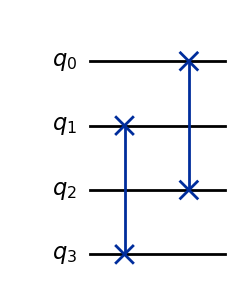

Instruction(name='c4 mod 15', num_qubits=5, num_clbits=0, params=[])
Here're the hard-coded U to multiplication operation for 7


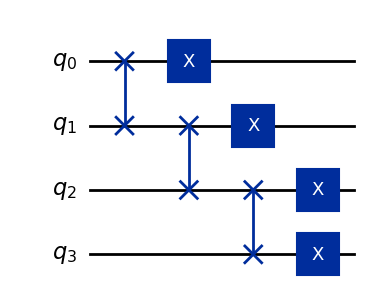

Instruction(name='c7 mod 15', num_qubits=5, num_clbits=0, params=[])
Here're the hard-coded U to multiplication operation for 8


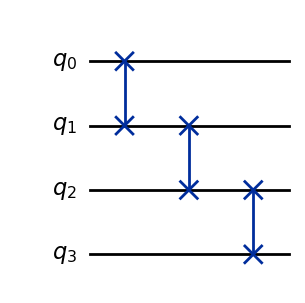

Instruction(name='c8 mod 15', num_qubits=5, num_clbits=0, params=[])
Here're the hard-coded U to multiplication operation for 11


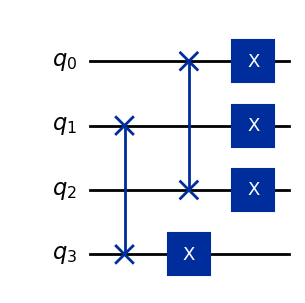

Instruction(name='c11 mod 15', num_qubits=5, num_clbits=0, params=[])
Here're the hard-coded U to multiplication operation for 13


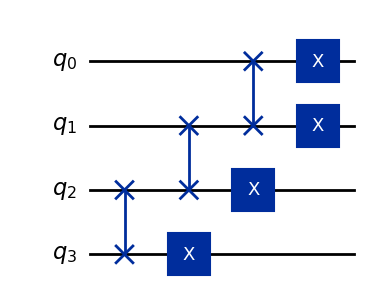

Instruction(name='c13 mod 15', num_qubits=5, num_clbits=0, params=[])


In [21]:
for i in [2,4,7,8,11,13]:
    print("Here're the hard-coded U to multiplication operation for", i)
    print(c_amod15(i))

Here's the phase estimation procedure from earlier implemented as a function.

In [22]:
def phase_estimation(
        controlled_operation: QuantumCircuit,
        psi_prep: QuantumCircuit,
        precision: int
    ):
    """
    Carry out phase estimation on a simulator.
    Args:
        controlled_operation: The operation to perform phase estimation on,
                              controlled by one qubit.
        psi_prep: Circuit to prepare |ψ>
        precision: Number of counting qubits to use
    Returns:
        float: Best guess for phase of U|ψ>
    """
    control_register = QuantumRegister(precision)
    output_register = ClassicalRegister(precision)

    target_register = QuantumRegister(psi_prep.num_qubits)
    qc = QuantumCircuit(control_register, target_register, output_register)

    # Prepare |ψ>
    qc.compose(psi_prep,
               qubits=target_register,
               inplace=True)

    # Do phase estimation
    for index, qubit in enumerate(control_register):
        qc.h(qubit)
        for _ in range(2**index):
            qc.compose(
                controlled_operation,
                qubits=[qubit] + list(target_register),
                inplace=True,
            )

    qc.compose(
        QFT(precision, inverse=True),
        qubits=control_register,
        inplace=True
    )

    qc.measure(control_register, output_register)

    measurement = Sampler().run(qc, shots=1).result().quasi_dists[0].popitem()[0]
    return measurement / 2**precision

We can't easily prepare eigenvectors of the multiplication by 
a∈Z*<small>15</small> operation, so we use ∣1⟩ as suggested above.

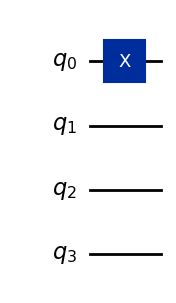

In [23]:
psi_prep = QuantumCircuit(4)
psi_prep.x(0)
display(psi_prep.draw('mpl'))

And finally we can run the circuit to try to find a nontrivial factor of 15.


Attempt 1


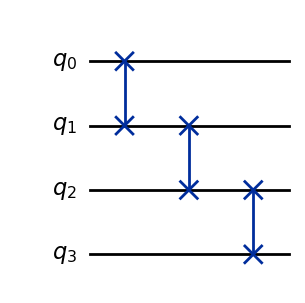

C:\Users\BBB\AppData\Local\Temp\ipykernel_8564\2139659180.py:45: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  measurement = Sampler().run(qc, shots=1).result().quasi_dists[0].popitem()[0]


Non-trivial factor found: 3


In [24]:
from fractions import Fraction
from math import gcd

a = 8
N = 15

FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\nAttempt {ATTEMPT}")

    phase = phase_estimation(
        c_amod15(a),
        psi_prep,
        precision=8
    )
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    if phase != 0:
        # Guess for a factor is gcd(x^{r/2} - 1 , 15)
        guess = gcd(a ** (r // 2) - 1, N)
        if guess not in [1, N] and (N % guess) == 0:
            # Guess is a factor!
            print(f"Non-trivial factor found: {guess}")
            FACTOR_FOUND = True